# Setup

In [11]:
%%capture
!pip install gymnasium pygame -q
!git clone https://github.com/MattChanTK/gym-maze.git
!cd gym-maze && python3 setup.py install

In [12]:
import numpy as np
from tqdm import tqdm # tqdm derives from the Arabic word taqaddum (تقدّم) which can mean “progress,” and is an abbreviation for “I love you so much” in Spanish (te quiero demasiado). Instantly make your loops show a smart progress meter - just wrap any iterable with tqdm(iterable), and you’re done!
import matplotlib.pyplot as plt

import gymnasium as gym

import warnings
warnings.filterwarnings('ignore')

In [13]:
gym.__version__

'0.29.1'

# Политика
## $\varepsilon$-Greedy Policy:
$$
\begin{array}{l}
\pi(a|s) =
\left\{
\begin{array}{ll}
1 - \varepsilon + \varepsilon / m,& \text{ если } a \in \mathrm{argmax}_{a' \in \mathcal{A}}\, Q(s,a'),\\
\varepsilon / m,& \text{ иначе }
\end{array}
\right.
\end{array}
$$

In [14]:
def get_epsilon_greedy_action(q_values, epsilon, action_n):

    policy = np.ones(action_n) * epsilon / action_n
    max_action = np.argmax(q_values)
    policy[max_action] += 1 - epsilon

    return np.random.choice(np.arange(action_n), p=policy)

# SARSA Algorithm
Пусть $Q(s,a) = 0$ и $\varepsilon = 1$.

Для каждого эпизода $k$ делаем:

Пока эпизод не закончен делаем:

1. Находясь в состоянии $S_t$ совершаем действие $A_t \sim \pi(\cdot|S_t)$,
где $\pi = \varepsilon\text{-greedy}(Q)$, получаем награду $R_t$, переходим в состояние $S_{t+1}$, совершаем действие $A_{t+1} \sim \pi(\cdot|S_{t+1})$

2. По $(S_t,A_t,R_t,S_{t+1},A_{t+1})$ обновляем $Q$:
$$
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha(R_t + \gamma Q(S_{t+1},A_{t+1}) - Q(S_t,A_t))
$$

Уменьшаем $\varepsilon$


In [15]:
def SARSA(env, episode_n, gamma=0.99, trajectory_len=500, alpha=0.5):
    total_rewards = np.zeros(episode_n)  # Создаем массив для хранения общих вознаграждений для каждого эпизода

    state_n = env.observation_space.n  # Получаем количество состояний в среде
    action_n = env.action_space.n  # Получаем количество действий в среде
    qfunction = np.zeros((state_n, action_n))  # Создаем Q-функцию (матрицу состояние-действие) и инициализируем её нулями

    for episode in range(episode_n):  # Запускаем цикл для каждого эпизода
        epsilon = 1 / (episode + 1)  # Уменьшаем параметр epsilon для epsilon-жадной стратегии с каждым эпизодом

        state = env.reset()[0]  # Сбрасываем среду и получаем начальное состояние
        action = get_epsilon_greedy_action(qfunction[state], epsilon, action_n)  # Получаем действие с использованием epsilon-жадной стратегии

        for _ in range(trajectory_len):  # Запускаем цикл для каждого шага внутри эпизода (ограниченного trajectory_len)
            next_state, reward, done, _, _ = env.step(action)  # Выполняем выбранное действие и получаем следующее состояние, вознаграждение и флаг завершения
            next_action = get_epsilon_greedy_action(qfunction[next_state], epsilon, action_n)  # Получаем следующее действие с использованием epsilon-жадной стратегии

            qfunction[state][action] += alpha * (reward + gamma * qfunction[next_state][next_action] - qfunction[state][action])  # Обновляем Q-функцию согласно формуле метода SARSA

            state = next_state  # Переходим в следующее состояние
            action = next_action  # Переходим в следующее действие

            total_rewards[episode] += reward  # Добавляем полученное вознаграждение к общему вознаграждению текущего эпизода

            if done:  # Если эпизод завершился, выходим из цикла
                break

    return total_rewards  # Возвращаем массив общих вознаграждений для каждого эпизода

In [8]:
total_rewards = SARSA(env, episode_n=500, trajectory_len=1000, gamma=0.999, alpha=0.5)

plt.plot(total_rewards)
plt.title('Динамика алгоритма SARSA')
plt.xlabel('Эпизод')
plt.ylabel('Общее вознаграждение')
plt.show()

NameError: name 'env' is not defined

# Q-Learning Algorithm

Пусть $Q_1(s,a) = Q_2(s,a) = 0$ и $\varepsilon = 1$.

Для каждого эпизода $k$ делаем:

Пока эпизод не закончен делаем:

Находясь в состоянии $S_t$ совершаем действие $A_t \sim \pi(\cdot|S_t)$,
    где $\pi = \varepsilon\text{-greedy}(Q)$, получаем награду $R_t$  переходим в состояние $S_{t+1}$.

По $(S_t,A_t,R_t,S_{t+1})$ обновляем $Q$:
    $$
    Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha(R_t + \gamma \max\limits_{a'} Q(S_{t+1},a') - Q(S_t,A_t))
    $$

Уменьшаем $\varepsilon$

In [16]:
def QLearning(env, episode_n, noisy_episode_n, gamma=0.99, t_max=500, alpha=0.5):
    state_n = env.observation_space.n  # Получаем количество состояний в среде
    action_n = env.action_space.n  # Получаем количество действий в среде

    Q = np.zeros((state_n, action_n))  # Создаем Q-функцию (матрицу состояние-действие) и инициализируем её нулями
    epsilon = 1  # Инициализируем действием рандомный шанс

    total_rewards = []  # Создаем массив для хранения общих вознаграждений для каждого эпизода
    for episode in range(episode_n):  # Запускаем цикл для каждого эпизода

        total_reward = 0  # Инициализируем общую сумму вознаграждений для каждого эпизода
        state, _ = env.reset()  # Инициализируем состояние и действие в среде

        for t in range(t_max):  # Запускаем цикл для каждого шага в эпизоде

            # Делаем действие с рандомным шансом epsilon

            action = get_epsilon_greedy_action(Q[state], epsilon, action_n)  # Делаем действие с шансом epsilo
            next_state, reward, done, _, _ = env.step(action)  # Делаем шаг в среде и получаем результат

            Q[state][action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state][action])  # Обновляем Q-функцию

            total_reward += reward  # Добавляем вознаграждение к общей сумме вознаграждений для эпизода

            if done:  # Если эпизод завершён, то выходим из цикла
                break

            state = next_state  # Обновляем состояние в среде

        epsilon = max(0, epsilon - 1 / noisy_episode_n)  # Обновляем действием шанс

        total_rewards.append(total_reward)  # Добавляем вознаграждение к общей сумме вознаграждений для эпизода

    return total_rewards  # Возвращаем общие вознаграждения для каждого эпизода

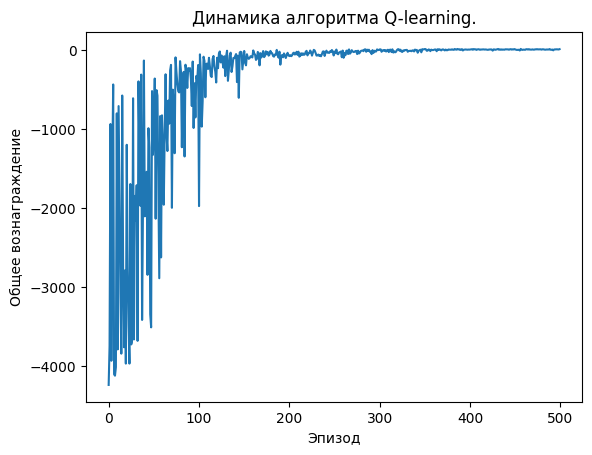

In [ ]:
total_rewards = QLearning(env, episode_n=500, noisy_episode_n=400, t_max=1000, gamma=0.999, alpha=0.5)

plt.plot(total_rewards)
plt.title('Динамика алгоритма Q-learning.')
plt.xlabel('Эпизод')
plt.ylabel('Общее вознаграждение')
plt.show()

# Double Q-Learning Algorithm

All the control algorithms that we have discussed so far involve maximization in the construction of
their target policies. For example, in Q-learning the target policy is the greedy policy given the current action values, which is deﬁned with a max, and in Sarsa the policy is often ε-greedy, which also involves a maximization operation. In these algorithms, a maximum over estimated values is used implicitly as an estimate of the maximum value, which can lead to a signiﬁcant positive bias. [Sutton, Barto]


Пусть $Q(s,a) = 0$ и $\varepsilon = 1$.

Для каждого эпизода $k$ делаем:

Пока эпизод не закончен делаем:

1. Находясь в состоянии $S_t$ совершаем действие $A_t \sim \pi(\cdot|S_t)$,
где $\pi = \varepsilon\text{-greedy}(Q_1 + Q_2)$, получаем награду $R_t$  переходим в состояние $S_{t+1}$.

2. По $(S_t,A_t,R_t,S_{t+1})$ обновляем $Q$:
С вероятностью 0.5
$$
Q_1(S_t,A_t) \leftarrow Q_1(S_t,A_t) + \alpha(R_t + \gamma \max\limits_{a'} Q_1(S_{t+1},a') - Q_1(S_t,A_t))
$$
Иначе
$$
Q_2(S_t,A_t) \leftarrow Q_2(S_t,A_t) + \alpha(R_t + \gamma \max\limits_{a'} Q_2(S_{t+1},a') - Q_2(S_t,A_t))
$$

Уменьшаем $\varepsilon$

In [21]:
import random

def DQLearning(env, episode_n, noisy_episode_n, gamma=0.99, t_max=500, alpha=0.5):
    state_n = env.observation_space.n  # Получаем количество состояний в среде
    action_n = env.action_space.n  # Получаем количество действий в среде

    Q1 = np.zeros((state_n, action_n))  # Создаем Q1-функцию (матрицу состояние-действие) и инициализируем её нулями
    Q2 = np.zeros((state_n, action_n))  # Создаем Q2-функцию (матрицу состояние-действие) и инициализируем её нулями
    epsilon = 1  # Инициализируем действием рандомный шанс

    total_rewards = []  # Создаем массив для хранения общих вознаграждений для каждого эпизода
    for episode in tqdm(range(episode_n)):  # Запускаем цикл для каждого эпизода

        total_reward = 0  # Инициализируем общую сумму вознаграждений для каждого эпизода
        state, _ = env.reset()  # Инициализируем состояние и действие в среде

        for t in range(t_max):  # Запускаем цикл для каждого шага в эпизоде

            # Делаем действие с рандомным шансом epsilon

            action = get_epsilon_greedy_action(Q1[state] + Q2[state], epsilon, action_n)  # Делаем действие с шансом epsilo
            next_state, reward, done, _, _ = env.step(action)  # Делаем шаг в среде и получаем результат

            if random.random() <= 0.5:
                Q1[state][action] += alpha * (reward + gamma * Q2[next_state][np.argmax( Q1[next_state])] - Q1[state][action])  # Обновляем Q-функцию
            else:
                Q2[state][action] += alpha * (reward + gamma * Q2[next_state][np.argmax( Q1[next_state])] - Q2[state][action])  # Обновляем Q-функцию

            total_reward += reward  # Добавляем вознаграждение к общей сумме вознаграждений для эпизода

            if done:  # Если эпизод завершён, то выходим из цикла
                break

            state = next_state  # Обновляем состояние в среде

        epsilon = max(0, epsilon - 1 / noisy_episode_n)  # Обновляем действием шанс

        total_rewards.append(total_reward)  # Добавляем вознаграждение к общей сумме вознаграждений для эпизода

    return total_rewards, Q1 + Q2  # Возвращаем общие вознаграждения для каждого эпизода

# Сравнение алгоритмов.

## Такси

В среде Taxi должно забирать пассажиров и доставлять их в пункт назначения на небольшой стоянке, двигаясь по кратчайшему пути.

In [18]:
env = gym.make("Taxi-v3")

In [23]:
total_rewards_SARSA = SARSA(  env, episode_n=500,             trajectory_len=1000, gamma=0.999, alpha=0.5)
total_rewards_Q = QLearning(  env, episode_n=500, noisy_episode_n=150, t_max=1000, gamma=0.999, alpha=0.5)
total_rewards_DQ, DQ_agent = DQLearning(env, episode_n=500, noisy_episode_n=150, t_max=1000, gamma=0.999, alpha=0.5)


import pandas as pd

total_rewards_SARSA_ma = pd.Series(total_rewards_SARSA).rolling(window=30).mean()
total_rewards_Q_ma = pd.Series(total_rewards_Q).rolling(window=30).mean()
total_rewards_DQ_ma = pd.Series(total_rewards_DQ).rolling(window=30).mean()

100%|██████████| 500/500 [00:08<00:00, 61.61it/s] 


### Сохранение агента

In [ ]:
pd.DataFrme(DQ_agent).to_csv( "DQ_Taxi_agent.csv")

### Суммарная и средняя награда за последние 100 эпизодов

In [24]:
print( "Суммарная награда за последние 100 эпизодов: ", pd.DataFrame( total_rewards_DQ).tail( 100 ).sum().values[0])
print( "Средняя награда за последние 100 эпизодов: ", pd.DataFrame( total_rewards_DQ).tail( 100 ).mean().values[0])

Суммарная награда за последние 100 эпизодов:  -458
Средняя награда за последние 100 эпизодов:  -4.58


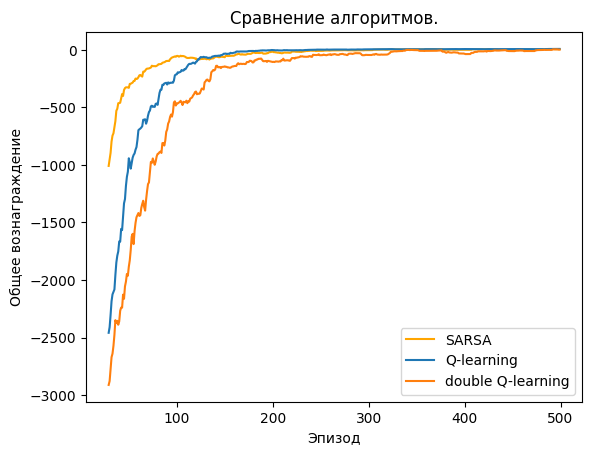

In [25]:
plt.plot(total_rewards_SARSA_ma, color='orange', label='SARSA')
plt.plot(total_rewards_Q_ma, label='Q-learning')
plt.plot(total_rewards_DQ_ma, label='double Q-learning')
plt.title('Сравнение алгоритмов.')
plt.xlabel('Эпизод')
plt.ylabel('Общее вознаграждение')
plt.legend()
plt.show()

# Создание класса

In [112]:
# Defining the Agent
class Agent_DQL():
    def __init__ (self, 
                n_actions, n_states, episode_n, noisy_episode_n, t_max
                  ):
        self.n_actions = n_actions
        self.n_states = n_states

        self.episode_n = episode_n
        self.noisy_episode_n = noisy_episode_n
        self.t_max = t_max
        self.gamma=0.999 
        self.alpha=0.5
        self.epsilon=1

        self.Q1 = np.zeros((n_states, n_actions))
        self.Q2 = np.zeros((n_states, n_actions))

        self.init_Q()

    def init_Q(self):
        for state in range(self.n_states):
            for action in range(self.n_actions):
                self.Q1[(state, action)] = 0.0
                self.Q2[(state, action)] = 0.0

    def choose_epsilon_greedy_action(self, state): 
        
        policy = np.ones( self.n_actions ) * self.epsilon / self.n_actions
        max_action = np.argmax( self.Q1[state] + self.Q2[state] )
        policy[max_action] += 1 - self.epsilon

        return np.random.choice(np.arange(self.n_actions), p=policy)
        
    def decrement_epsilon(self):    
        self.epsilon = max(0, self.epsilon - 1 / self.noisy_episode_n)

    def learn_DQL(self, state, action, reward, state_):
        # = choose_epsilon_greedy_action(self, self.Q1 + self.Q2, state_) 
        
        if random.random() <= 0.5:
            self.Q1[state][action] += self.alpha * (reward + self.gamma * self.Q2[state_][np.argmax( self.Q1[state_])] - self.Q1[state][action])  # Обновляем Q1-функцию
        else:
            self.Q2[state][action] += self.alpha * (reward + self.gamma * self.Q1[state_][np.argmax( self.Q2[state_])] - self.Q2[state][action])  # Обновляем Q2-функцию


In [ ]:
# A simple plot
def plot_learning_curve(x, scores, epsilons):
    fig = plt.figure()
    ax = fig.add_subplot(111, label = "1")
    ax2 = fig.add_subplot(111, label = "2", frame_on = False)

    ax.plot(x, epsilons, color = "C0")
    ax.set_xlabel("Training Steps", color = "C0")
    ax.set_ylabel("Epsilon", color = "C0")
    ax.tick_params(axis = 'x', colors = "C0")
    ax.tick_params(axis = 'y', colors = "C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(scores[max(0, t-100):(t+1)])

    ax2.scatter(x, running_avg, color = "C1")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Score', color = "C1")
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis = 'y', colors = "C1")

In [110]:
agent = Agent_DQL(
    n_actions = env.action_space.n,
    n_states = env.observation_space.n,
    episode_n = 500, 
    noisy_episode_n = 150, 
    t_max = 1000
    )

In [111]:
def DQLearning2(env, agent):
    #state_n = env.observation_space.n  # Получаем количество состояний в среде
    #1action_n = env.action_space.n  # Получаем количество действий в среде

    total_rewards = []  # Создаем массив для хранения общих вознаграждений для каждого эпизода
    for episode in tqdm(range(agent.episode_n)):  # Запускаем цикл для каждого эпизода

        total_reward = 0  # Инициализируем общую сумму вознаграждений для каждого эпизода
        state, _ = env.reset()  # Инициализируем состояние и действие в среде

        for t in range(agent.t_max):  # Запускаем цикл для каждого шага в эпизоде

            # Делаем действие с рандомным шансом epsilon
            action = agent.choose_epsilon_greedy_action( state)
            
            #action = get_epsilon_greedy_action(Q1[state] + Q2[state], epsilon, action_n)  # Делаем действие с шансом epsilo
            next_state, reward, done, _, _ = env.step(action)  # Делаем шаг в среде и получаем результат

            agent.learn_DQL( state, action, reward, next_state)

            total_reward += reward  # Добавляем вознаграждение к общей сумме вознаграждений для эпизода

            if done:  # Если эпизод завершён, то выходим из цикла
                break

            state = next_state  # Обновляем состояние в среде

        agent.decrement_epsilon()
        #epsilon = max(0, epsilon - 1 / noisy_episode_n)  # Обновляем действием шанс

        total_rewards.append(total_reward)  # Добавляем вознаграждение к общей сумме вознаграждений для эпизода

    return total_rewards, agent.Q1 + agent.Q2  # Возвращаем общие вознаграждения для каждого эпизода

In [107]:
total_rewards_SARSA = SARSA(  env, episode_n=500,             trajectory_len=1000, gamma=0.999, alpha=0.5)
total_rewards_Q = QLearning(  env, episode_n=500, noisy_episode_n=150, t_max=1000, gamma=0.999, alpha=0.5)
total_rewards_DQ, DQ_agent = DQLearning2(env, agent)


import pandas as pd

total_rewards_SARSA_ma = pd.Series(total_rewards_SARSA).rolling(window=30).mean()
total_rewards_Q_ma = pd.Series(total_rewards_Q).rolling(window=30).mean()
total_rewards_DQ_ma = pd.Series(total_rewards_DQ).rolling(window=30).mean()



100%|██████████| 500/500 [00:06<00:00, 74.79it/s] 


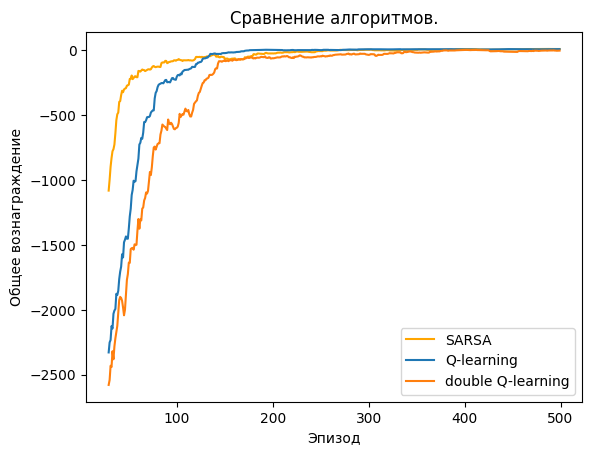

In [108]:
plt.plot(total_rewards_SARSA_ma, color='orange', label='SARSA')
plt.plot(total_rewards_Q_ma, label='Q-learning')
plt.plot(total_rewards_DQ_ma, label='double Q-learning')
plt.title('Сравнение алгоритмов.')
plt.xlabel('Эпизод')
plt.ylabel('Общее вознаграждение')
plt.legend()
plt.show()